# Quantum Annealing schedules
#### Liza Darwesh 500793232

### In this notebook you will find the following things:

Anneal Schedules:
- with Pause
- with Quench
- with a combination of pauses and quenches

The schedules have been applied on the Ising model based on the following calculation:

Ising Hamiltonian Model 

### $H = - \sum \limits _{j} h_{j} Z_{j} - \sum \limits _{i,j} J_{i,j} Z_{i} Z_{j} + \gamma$

Where the coefficients h and J define, respectively, the mapped portfolio model as followed:

### $J_{i,j} = -\frac{1}{4} (\theta_{2}Cov(R_{i},R_{j}) + \theta_{3}A_{i}A_{j})$ 

### $h_{i}= - \frac{1}{2}(\theta_{2}Cov(R_{i},R_{i}) + \theta_{3}A^2_{i} - \theta_{1}E(R_{i}) - 2B\theta_{3}A_{i})$ 

where  

$A_{i}$ is the maximum amount of money that can be invested in the i-th asset; 

$B$ the total budget, in my case 200; 

$R_{i}$ denoting the variable representing the return from asset i; 

and $Cov(R_{i},R_{j})$ the co-variance of the variables $R_{i}$ and $R_{j}$.

The gamma coefficient has not been taken in account in the Ising model, but to complete the mapping of the quadratic unconstrained binary optimization into the Ising model, gamma is defined as: 

### $\gamma = \theta_{3}B^2$

[source](https://www.osti.gov/servlets/purl/1423041)

This notebook makes use of the actual Quantum Computer solver DWaveSampler(), where a QPU time is limited. It is possible to renew your QPU time every month for free. The last few cells consist of a combination of dimod and the DwaveSampler().



In [1]:
from dwave.system.samplers import DWaveSampler
from dwave.system import EmbeddingComposite

sampler = DWaveSampler()

In [2]:
annealing_range = sampler.properties["annealing_time_range"]
max_slope = 1.0/annealing_range[0]
print("Annealing time range: {}".format(sampler.properties["annealing_time_range"]))
print("Maximum slope:", max_slope)

Annealing time range: [1, 2000]
Maximum slope: 1.0


In [3]:
# Use NumPy and Bokeh for plotting
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

# Print the full anneal schedule
schedule = [[0.0,0.0], [50.0, 0.5], [250.0, 0.5], [300, 1.0]]
print("Schedule: %s" % schedule)

# Plot the anneal schedule
p = figure(title="Example Anneal Schedule with Pause", x_axis_label='Time [us]', y_axis_label='Annealing Parameter s')
p.line(*np.array(schedule).T)
show(p)

Loading BokehJS ...

Schedule: [[0.0, 0.0], [50.0, 0.5], [250.0, 0.5], [300, 1.0]]


In [4]:
schedule=[[0.0,0.0],[12.0,0.6],[12.8,1.0]]
print("Schedule: %s" % schedule)
p = figure(title="Example Anneal Schedule with Quench", x_axis_label='Time [us]', y_axis_label='Annealing Parameter s')
p.line(*np.array(schedule).T)
show(p)

Schedule: [[0.0, 0.0], [12.0, 0.6], [12.8, 1.0]]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
schedule=[[0.0, 0.0], [40.0, 0.4], [90.0, 0.4], [91.2, 1.0]]
print("Schedule: %s" % schedule)
p = figure(title="Example Anneal Schedule with Pause and Quench", x_axis_label='Time [us]', y_axis_label='Annealing Parameter s')
p.line(*np.array(schedule).T)
show(p)

Schedule: [[0.0, 0.0], [40.0, 0.4], [90.0, 0.4], [91.2, 1.0]]


In [6]:
#-------------------------------------------------------------------------
#                       Test bias and coupler
#-------------------------------------------------------------------------

# h = {0: 1.0, 1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: -1.0, 6: 0.0, 7: 1.0,
#      8: 1.0, 9: -1.0, 10: -1.0, 11: 1.0, 12: 1.0, 13: 0.0, 14: -1.0, 15: 1.0}
# J = {(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1,
#      (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1,
#      (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1,
#      (2, 5): -1, (2, 4): -1, (6, 14): -1}

In [7]:

import datetime
import pandas as pd
import pandas_datareader.data as web

def covariance(a,b):
    return a.cov(b)

def hi(name, price, returns, cov):

    # mean expected return
    E = np.mean(returns)

    # hi = -(1/2)((1/3)*cov(Ri,Ri) + (1/3)Ai^2 - (1/3)E(Ri) - 2B(1/3)*Ai)
    h_term = -0.5*((1/3)*cov + (1/3)* (Ai ** 2) - (1/3)* E - 2*B*(1/3)*Ai)
    h[name] = h_term

def Ji(name_i, name_j, cov):
    # Ji,j = -(1/4)((1/3)*cov(Ri,Rj) + (1/3)AiAj)
    coupler = -(0.25)*((1/3)*cov + ((1/3)*Ai*Aj))
    J[(name_i, name_j)] = coupler
    
def price_assets(a):
    all_data = {asset : web.get_data_yahoo(asset,start,end)
          for asset in a} 
    price = pd.DataFrame({asset : data['Adj Close']
                    for asset , data in all_data.items()})
    return price

def returns_assets(a):
    price_all_assets = price_assets(a)
    returns_unclean = price_all_assets.pct_change()
    returns_clean = returns_unclean.dropna()
    return returns_clean

# Money that can be invested
Ai = 50
Aj = 50
# Total budget
B = 200

#Dictorionary J and h terms
J = {}
h = {}

# Date of assets
start = datetime.datetime(2018,1,3)       
end = datetime.datetime(2021,1,1)

# Assets to work with
assets_dict = {'apple':'AAPL','ibm':'IBM','microsoft':'MSFT','google':'GOOGL'}

assets = []
asset_names = []
cov_assets = {}
cov_assets_coupled = {}

for key, value in assets_dict.items():
    asset_names.append(key)
    assets.append(value)

price = price_assets(assets)
returns = returns_assets(assets) 

# Covariance of the assets with themselves, 4 items
for i in assets:
    cov = covariance(returns[i], returns[i])
    cov_assets[i] = cov
    
# Covariance of the assets with each other, 6 items
for i in range(len(assets)):
    for j in range(i + 1, len(assets)):
        if j < len(assets):
            cov = covariance(returns[assets[i]], returns[assets[j]])
        else:
            j = 0
            cov = covariance(returns[assets[i]], returns[assets[j]])
        cov_assets_coupled[assets[i],assets[j]] = cov
        
for i in range(len(assets)):
    hi(asset_names[i], price[assets[i]], returns[assets[i]], cov_assets[assets[i]])

for key1, key2 in cov_assets_coupled:
    Ji(key1, key2, cov_assets_coupled[key1,key2])

In [8]:
# To see helper functions, select Jupyter File Explorer View from the Online Learning page
#from helpers.embedding import DirectEmbeddingComposite

sampler_embedded = EmbeddingComposite(sampler)

In [9]:
runs=1000
results = sampler_embedded.sample_ising(h, J, 
    num_reads=runs,
    label='Notebook - Anneal Schedule',
    annealing_time=100)

print("QPU time used:", results.info['timing']['qpu_access_time'], "microseconds.")
print(results)

QPU time used: 191248 microseconds.
   AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc. ...
0    +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228     460 ...
1    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228     510 ...
2    -1    -1  +1   -1    -1     -1  -1        -1 -11666.667116       3 ...
3    +1    +1  -1   +1    -1     -1  -1        -1 -11666.667116       1 ...
4    +1    -1  +1   +1    -1     -1  -1        -1  -11666.66709       4 ...
5    -1    +1  -1   -1    -1     -1  -1        -1  -11666.66709       3 ...
6    +1    -1  -1   -1    -1     -1  -1        -1 -11666.667084       1 ...
7    -1    +1  +1   +1    -1     -1  -1        -1 -11666.667084      10 ...
8    +1    +1  +1   -1    -1     -1  -1        -1 -11666.667078       1 ...
9    -1    -1  -1   +1    -1     -1  -1        -1 -11666.667078       3 ...
10   +1    -1  +1   -1    -1     -1  -1        -1 -11250.000379       1 ...
11   -1    +1  -1   +1    -1     -1  -1        -1 -1

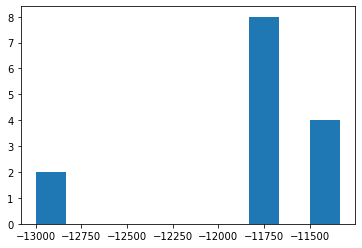

In [10]:
plt.hist(results.record.energy,rwidth=1,align='left')
plt.show()

In [12]:
import pandas as pd
import json
with open("files/saved_pause_results.json", "r") as read_file:
    saved_pause_success_prob = pd.read_json(json.load(read_file))

In [13]:
from itertools import cycle

# set up some plot decoration values
all_colors = ["dodgerblue", "orange", "darkorchid"]
all_lines = ["4 1 4", "4 4", "4 0"]
all_markers = ["circle", "square", "triangle", "diamond"]

p = figure(title="Success fraction using pause for a range of anneal schedule parameters",
           x_axis_label='s at pause start',
           y_axis_label='ground state fraction',
           y_axis_type='log',
           y_range=[1e-3, 0.65],
           plot_height=960,
           plot_width=960)

colors = cycle(all_colors)
lines = cycle(all_lines)
for anneal,a_group in saved_pause_success_prob.groupby('anneal_time'):
    col = next(colors)
    line = next(lines)
    
    markers = cycle(all_markers)
    for pause,p_group in a_group.groupby('pause_duration'):
        marker = next(markers)
        legend = "anneal={}, pause={}".format(anneal,pause)
        
        x = p_group["s_feature"]
        y = p_group["success_frac"]
        p.line(x, y, legend_label=legend, color=col, line_dash=line, line_width=2)
        p.scatter(x, y, legend_label=legend, color=col, marker=marker, size=8)
    
p.legend.location = "top_left"
show(p)

In [14]:
#Update the standard anneal schedule parameters below: 

anneal_time = 10.0
pause_duration = 500.0      # Must be greater than 0
pause_start = 0.4        # Must be between 0 and 1

schedule=[[0.0,0.0],[pause_start*anneal_time,pause_start],[pause_start*anneal_time+pause_duration, pause_start],[anneal_time+pause_duration, 1.0]]
runs=900
results = sampler_embedded.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                label='Notebook - Anneal Schedule',                        
                num_spin_reversal_transforms=1)
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

p.scatter([pause_start],[success], color="red")
show(p)
print("QPU time used:", results.info['timing']['qpu_access_time'], "microseconds.")
print(results)

Success probability:  0.0


QPU time used: 538780 microseconds.
   AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc. ...
0    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228     355 ...
1    +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228     477 ...
2    +1    +1  -1   +1    -1     -1  -1        -1 -11666.667116      13 ...
3    -1    -1  +1   -1    -1     -1  -1        -1 -11666.667116      11 ...
4    -1    +1  -1   -1    -1     -1  -1        -1  -11666.66709       4 ...
5    +1    -1  +1   +1    -1     -1  -1        -1  -11666.66709       9 ...
6    -1    +1  +1   +1    -1     -1  -1        -1 -11666.667084      14 ...
7    +1    -1  -1   -1    -1     -1  -1        -1 -11666.667084       3 ...
8    -1    -1  -1   +1    -1     -1  -1        -1 -11666.667078       4 ...
9    +1    +1  +1   -1    -1     -1  -1        -1 -11666.667078       6 ...
10   +1    -1  -1   +1    -1     -1  -1        -1 -11250.000382       2 ...
11   +1    -1  +1   -1    -1     -1  -1        -1 -1

In [15]:
with open("files/saved_quench_results.json", "r") as read_file:
    saved_quench_success_prob = pd.read_json(json.load(read_file))

In [16]:
p = figure(title="Success fraction using quench for a range of anneal schedule parameters",
           x_axis_label='s at quench start',
           y_axis_label='ground state fraction',
           y_axis_type='log',
           y_range=[1e-4, 0.5],
           plot_height=960,
           plot_width=960)

colors = cycle(all_colors)
lines = cycle(all_lines)
for anneal,a_group in saved_quench_success_prob.groupby('anneal_time'):
    col = next(colors)
    line = next(lines)
   
    markers = cycle(all_markers)
    for quench,p_group in a_group.groupby('quench_slope'):
        marker = next(markers)
        legend = "anneal={}, quench slope={}".format(anneal,quench)
        
        x = p_group["s_feature"]
        y = p_group["success_frac"]
        p.line(x, y, legend_label=legend, color=col, line_dash=line, line_width=2)
        p.scatter(x, y, legend_label=legend, color=col, marker=marker, size=8)

p.legend.location = "top_left"
show(p)

In [17]:
#Update the standard anneal schedule parameters below 

anneal_time = 50.0
quench_slope = 1.0      # Must be greater than 0
quench_start = 0.2      # Must be between 0 and 1

schedule=[[0.0,0.0],[quench_start*anneal_time,quench_start],[(1-quench_start+quench_slope*quench_start*anneal_time)/quench_slope, 1.0]]
runs=950
results = sampler_embedded.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',
                num_spin_reversal_transforms=1)
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

p.scatter([quench_start],[success], color="red")
show(p)
print("QPU time used:", results.info['timing']['qpu_access_time'], "microseconds.")
print(results)

Success probability:  0.0


QPU time used: 91257 microseconds.
    AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc. ...
0     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
1     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
2     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
3     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
5     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
6     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
7     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
8     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
9     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
10    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
11    +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
12    +1    +1  +1   +1    -1     -1  -1 

In [18]:
anneal_time=[10.0, 100.0, 500.0]
pause_duration=[10.0, 100.0, 500.0]

# Create list of start times
num_points=5
s_low=0.2
s_high=0.6
pause_start=np.linspace(s_low, s_high, num=num_points)

success_prob = pd.DataFrame(index=range(len(anneal_time)*len(pause_duration)*len(pause_start)),
                                columns=["anneal_time", "pause_duration", "s_feature", "success_frac"],
                                data=None)
counter=0

print("Starting QPU calls...")
QPU_time=0.0
for anneal in anneal_time:
    for pause in pause_duration:
        for start in pause_start:
            schedule=[[0.0,0.0],[start*anneal,start],[start*anneal+pause, start],[anneal+pause, 1.0]]
            runs=950
            results = sampler_embedded.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',
                num_spin_reversal_transforms=1)
            success_prob.iloc[counter]={"anneal_time":anneal, 
                                        "pause_duration":pause, 
                                        "s_feature":start,
                                        "success_frac":np.count_nonzero(results.record.energy == -20.0)/runs}
            counter+=1
            QPU_time+=results.info['timing']['qpu_access_time']
        #print("QPU calls remaining: ", len(anneal_time)*len(pause_duration)*len(pause_start)-counter)
            
print(results)

Starting QPU calls...
    AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc. ...
0     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
1     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
2     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
3     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
4     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
5     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
6     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
7     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
8     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
9     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
10    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
11    -1    -1  -1   -1    -1     -1  -1        -1 -12

In [19]:
anneal_time=[10.0, 100.0, 500.0]
quench_slopes=[1.0, 0.5, 0.25]

# start times
num_points=5
s_low=0.2
s_high=0.9
quench_start=np.linspace(s_low, s_high, num=num_points)

success_prob = pd.DataFrame(index=range(len(anneal_time)*len(quench_slopes)*len(quench_start)),
                                columns=["anneal_time", "quench_slope", "s_feature", "success_frac"],
                                data=None)
counter=0

print("Starting QPU calls...")
QPU_time=0.0
for anneal in anneal_time:
    for quench in quench_slopes:
        for start in quench_start:
            schedule=[[0.0,0.0],[start*anneal,start],[(1-start+quench*start*anneal)/quench, 1.0]]
            runs=1000
            results = sampler_embedded.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',
                num_spin_reversal_transforms=1)
            success_prob.iloc[counter]={"anneal_time":anneal, 
                                        "quench_slope":quench, 
                                        "s_feature":start,
                                        "success_frac":np.count_nonzero(results.record.energy == -20.0)/runs}
            counter+=1
            QPU_time+=results.info['timing']['qpu_access_time']
        #print("QPU calls remaining: ", len(anneal_time)*len(quench_slopes)*len(quench_start)-counter)
            
print(results)

Starting QPU calls...
    AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc. ...
0     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
1     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
2     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
3     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
5     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
6     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
7     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
8     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1 ...
9     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
10    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
11    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1 ...
12    -1    -1  -1   -1    -1     -1  -1        -1 -12